# Прогнозирование стоимости автомобиля по характеристикам

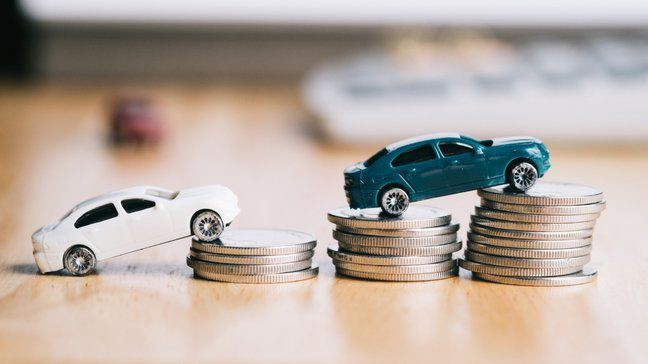

Задача: создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. 

Оценка: оценка модели  проводится по **MAPE** (Mean Absolute Percentage Error) по средней относительной ошибки прогноза.


По условию соревнования, нам нужно самостоятельно собрать обучающий датасет.


# Библиотеки и функции

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import statistics
from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime

import matplotlib.pyplot as plt  # для отрисовки графиков
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
#from catboost import CatBoostRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_classif, mutual_info_classif

#from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
#показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
Numpy        : 1.18.5


In [4]:
# зафиксируем версии пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция, которая  ищет пересечение уникальных значений признаков.
def intersection_cols(col1,col2):   
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print(len(col1_set),len(col2_set),len(intersection))

In [8]:
# Функция выводит инфорамцию о границах выборосов для признака.
def iqr_test(series, mode=False):
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR

    if mode:
        return low, up

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{low}, {up}].".format(
            low=perc25 - 1.5*IQR, up=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < low:
        print("Найдены выбросы по нижней границе признака: Количество: {}, {}%".format(series.where(
            series < low).count(), round(series.where(series < low).count()/series.count()*100, 2)))
    if series.max() > up:
        print("Найдены выбросы по верхней границе признака: Количество: {}, {}%".format(series.where(
            series > up).count(), round(series.where(series > up).count()/series.count()*100, 2)))

In [9]:
# Функция для отрисовки коробочной диаграммы для нечисловых признаков.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=df[df['sample'] == 1],
                ax=ax)
    plt.xticks(rotation=45)

    ax.set_ylim(0, (df.price.quantile(0.75) + 8 *
                    (df.price.quantile(0.75) - df.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column + 'price')
    plt.show()

# Setup

```
VERSION = 16
# подключаем к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%
```

 ```
 !ls '../input'
 ```

# Загрузка данных и предварительный анализ

Загрузим тестовый и тренировочный датасеты и проанализируем их для унификации.

In [12]:
train= pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')

```
#датасет для обучения модели
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')
```

In [13]:
train.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
9284,Внедорожник 5 дв.,BMW,040001,дизель,2010.0,20d xDrive 2.0d AT (184 л.с.) 4WD,5.0,2011,ALLROAD_5_DOORS AUTOMATIC 20d,AUTOMATIC,20d,184.0,ПТС оригинал.\n\n1 Владелец.\n\nПолный комплек...,68000,{'id': '0'},полный,LEFT,NaN,1.0,ORIGINAL,True,NaN,1349900.0,2020-09-07T13:47:58Z,NaN,X3
67342,Внедорожник 5 дв.,TOYOTA,040001,дизель,2002.0,105 4.2d MT (131 л.с.) 4WD,5.0,2004,ALLROAD_5_DOORS MECHANICAL 105,MECHANICAL,105,131.0,"Автомобиль куплен в Твери,от 1го хозяина с про...",256707,{'id': '0'},полный,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2012, 'month': 3}",1750000.0,2019-12-29T19:24:17Z,NaN,LAND_CRUISER
831,Седан,AUDI,040001,бензин,2011.0,2.0 AMT (211 л.с.) 4WD,4.0,2013,SEDAN ROBOT 2.0,ROBOT,2.0,211.0,Автомобиль покупался мною в 2017 году с пробег...,104000,{'id': '0'},полный,LEFT,NaN,2.0,ORIGINAL,True,"{'year': 2017, 'month': 4}",990000.0,2020-08-21T06:49:18Z,NaN,A4


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [15]:
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
24432,хэтчбек 3 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,серый,NaN,"Автомобиль в прекрасном состоянии, продажа от ...",1.2 LTR,105 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,202000,2009,"{""code"":""POLO"",""name"":""Polo"",""ru_name"":""Поло"",...",POLO,1.2 AMT (105 л.с.),3,1603217565,RUB,2010,1101116244,"{""id"":""6100566"",""displacement"":1197,""engine_ty...",HATCHBACK_3_DOORS ROBOT 1.2,роботизированная,EUROPEAN,3 или более,2 года и 9 месяцев,Дубликат,передний,Левый,Не требует ремонта,Растаможен
22837,внедорожник 5 дв.,LEXUS,https://auto.ru/cars/used/sale/lexus/rx/108963...,чёрный,"{""id"":""6498909"",""name"":""Premium"",""available_op...",Машина в идеальном состоянии!\n\nЦЕНА ОКОНЧАТЕ...,3.5 LTR,277 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/imflT9272/520f62I9/2...,140000,2008,"{""code"":""RX"",""name"":""RX"",""ru_name"":""RX"",""morph...",RX,350 3.5 AT (277 л.с.) 4WD,5,1603300873,RUB,2011,1089636931,"{""id"":""4664921"",""name"":""350"",""nameplate"":""350""...",ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,JAPANESE,2 владельца,6 лет и 6 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
369,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,NaN,100 % ГАРАНТИИ ЮРИДИЧЕСКОЙ ЧИСТОТЫ...!!! УХОЖЕ...,1.8 LTR,152 N12,"{""asr"":true,""alloy-wheel-disks"":true,""tinted-g...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,172000,2008,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603227706,RUB,2011,1101224951,"{""id"":""21066001"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
20471,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/corolla/...,серебристый,NaN,Безопасность: 3. Комфорт: 4. Салон: 2. Защита ...,1.6 LTR,110 N12,"{""airbag-passenger"":true,""condition"":true,""pow...",бензин,https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,212303,2003,"{""code"":""COROLLA"",""name"":""Corolla"",""ru_name"":""...",COROLLA,1.6 MT (110 л.с.),4,1603291883,RUB,2006,1101111448,"{""id"":""6390360"",""displacement"":1598,""engine_ty...",SEDAN MECHANICAL 1.6,механическая,JAPANESE,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
18693,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/gl_kla...,бежевый,"{""id"":""2442759"",""name"":""500"",""available_option...",Продаю очень ухоженный автомобиль в отличнейше...,5.5 LTR,388 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,101000,2006,"{""code"":""GL_KLASSE"",""name"":""GL-Класс"",""ru_name...",GL_KLASSE,500 5.5 AT (388 л.с.) 4WD,5,1603252606,RUB,2008,1083208420,"{""id"":""2307898"",""name"":""500"",""nameplate"":""500""...",ALLROAD_5_DOORS AUTOMATIC 5.5,автоматическая,EUROPEAN,1 владелец,10 лет и 11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Как мы видим в тренировочном и тестовом датасетах есть различия. В тренировочном датасете не хватает некоторых данных. И в обоих датасетах есть пропуски. В тренировочном датасете в двух колонках состояние и hidden отсутствуют данные.

Сейчас проверим различие колонок в train и test.

In [17]:
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['sell_id', 'priceCurrency', 'super_gen', 'model_info', 'image', 'model_name', 'equipment_dict', 'car_url', 'parsing_unixtime', 'complectation_dict', 'vendor']
Список колонок, которые есть только в train: ['Комплектация', 'hidden', 'start_date', 'model', 'price']


В тестовом датасете 11 признаков, которых нет в тренировочном. 5 признаков есть только в тренировочном датасете, которых нет в тестовом. Однако, среди них price- это наш таргет, который требуется определить для теста, поэтому его оставляем.

В столбце hidden нет данных вообще, поэтому он под удаление.
Столбец "Комплектация" в train соответствует столбцу complectation_dict в test, но поскольку оба столбца содержат много порпусков, удалим эти столбцы в test и в train.
Столбец start_date от сутствует в test, поэтому он тоже под удаление.

In [18]:
train.drop(['hidden', 'start_date','Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

Столбцы train.model и test.model_name содержат одинаковую информацию о наименовании модели, поэтому просто переименуем этот столбец в тренировочном датасете.

In [19]:
train.rename(columns={'model': 'model_name'}, inplace=True)

In [20]:
# Еще раз проверим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['sell_id', 'equipment_dict', 'car_url', 'priceCurrency', 'super_gen', 'parsing_unixtime', 'vendor', 'model_info', 'image']
Список колонок, которые есть только в train: ['price']


In [21]:
# Добавим в тестовый датасет признак price = 0, чтобы при объединении датасетов не возникло NaN значение
test['price'] = 0.0
# Добавим столбец с sell_id в тренировочный датафрейм изаполним его нулями:
train['sell_id'] = 0

#### Удаление столбцов в test

Что касается остальных восьми признаков ('image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info', 'super_gen', 'parsing_unixtime'), то их будем удалять. Удаление priceCurrency и model_inf' не должно повлиять на данные, поскольку валюта продаж это рубли, а в столбе model_info продублирована марка авто.

In [22]:
test.priceCurrency.value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

In [23]:
test.model_info[10]

'{"code":"RAPID","name":"Rapid","ru_name":"Рапид","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Переведя формат даты в столбце parsing_unixtime  в обычный видим, что интервал дат сосредоточен с 19 по 26 октября 2020 года. И это нам вряд ли будет полезно.

In [24]:
test.parsing_unixtime = pd.to_datetime(test.parsing_unixtime, unit='s')
print(test.parsing_unixtime.min())
print(test.parsing_unixtime.max())

2020-10-19 11:35:06
2020-10-26 11:04:24


В equipment_dict имеются пропуски. Кроме того, из-за отсутствия парсинга нет возможности заполнить такие столбцы тренировочном сете, поэтому удаляем оставшиеся 8 в тестовом датасете:

In [25]:
test.drop(['image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info', 'super_gen', 'parsing_unixtime'], axis=1, inplace=True)

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   description           34686 non-null  object 
 4   engineDisplacement    34686 non-null  object 
 5   enginePower           34686 non-null  object 
 6   fuelType              34686 non-null  object 
 7   mileage               34686 non-null  int64  
 8   modelDate             34686 non-null  int64  
 9   model_name            34686 non-null  object 
 10  name                  34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  sell_id               34686 non-null  int64  
 14  vehicleConfiguration  34686 non-null  object 
 15  vehicleTransmission

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Привод                89377 non-null  object 
 15  Руль               

Также следует удалить в обоих дата сетах признаки 'Состояние' и'Владение', поскольку в тренировочном датасете первый вообще не содержит информации (одни пропуски), а второй признак имеет много пропусков и в test и в train. В тестовом датасете в признаке Состояние- все автомобили не требуют ремонта, что и понятно (вряд ли владелец будет сообщать о его необходимости, чтобы не уменьшить продажную цену).

In [28]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [29]:
test.drop(['Состояние', 'Владение'], axis=1, inplace=True)
train.drop(['Состояние', 'Владение'], axis=1, inplace=True)

# EDA

Перед объединением датасетов проверим типы данных в train и test.
Сгенерируем список с колонками, которые есть и в train, и в test:

In [30]:
cols_cross = list(set(test.columns).intersection(train.columns))
cols_diff_type = []  # создаем список с колонками, в которых типы данных отличаются

for col in cols_cross:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t столбец {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_diff_type.append(col)

	 столбец Владельцы: для train - <class 'numpy.float64'>, для test - <class 'str'>
	 столбец numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>
	 столбец Таможня: для train - <class 'numpy.bool_'>, для test - <class 'str'>


In [31]:
# Приводим данные в колонках к одному типу, там, где это возможно

train.numberOfDoors = train.numberOfDoors.astype('Int64')
train.modelDate = train.modelDate.astype('Int64')

Разберем отдельно оставшиеся признаки с разными типами данных:

#### Таможня

In [32]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

In [33]:
train['Таможня'].value_counts()

True    89378
Name: Таможня, dtype: int64

Т.к. все машины расстаможены, в нем нет необходимости. Под удаление.

In [34]:
test.drop(['Таможня'], axis=1, inplace=True)
train.drop(['Таможня'], axis=1, inplace=True)

#### enginePower

In [35]:
test.enginePower.value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
338 N12       1
591 N12       1
42 N12        1
324 N12       1
402 N12       1
Name: enginePower, Length: 315, dtype: int64

In [36]:
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [37]:
train.enginePower.value_counts()

150.0    7058
249.0    3721
140.0    2898
105.0    2360
123.0    2302
         ... 
477.0       1
232.0       1
251.0       1
591.0       1
526.0       1
Name: enginePower, Length: 396, dtype: int64

In [38]:
train.enginePower.unique()

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       218., 210., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 192., 286.,  98., 234., 171.,  46.,  51.,
       407., 530., 313., 235., 381., 462., 197., 109., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 276., 226., 175., 203., 311.,
       215., 322., 309., 185., 564., 330., 304., 40

In [39]:
# Данные test и train лучше перевести  целые числа:

train.enginePower = train.enginePower.astype('Int64')

In [40]:
# функция для перевода test.enginePower  в целые числа:
def enginePower_int(x):
    x = str(x).split(' ')[0]
    if x == 'nan' or x == 'undefined':
        return np.nan
    return int(x)

In [41]:
test.enginePower = test.enginePower.apply(enginePower_int)

In [42]:
train.enginePower

0        174
1         90
2        136
3         90
4        101
        ... 
89373    163
89374    163
89375    149
89376    149
89377    149
Name: enginePower, Length: 89378, dtype: Int64

In [43]:
test.enginePower

0        105
1        110
2        152
3        110
4        152
        ... 
34681    136
34682    190
34683    170
34684    184
34685    235
Name: enginePower, Length: 34686, dtype: int64

#### Владельцы

In [44]:
test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [45]:
train['Владельцы'].unique()

array([ 3.,  1.,  2., nan])

In [46]:
# Преобразуем значения в test в числовые (float) для этого создадим словарь:
dict_owners = {'3 или более': 3., '2\xa0владельца': 2., '1\xa0владелец': 1.}

test['Владельцы'].replace(dict_owners, inplace=True)

In [47]:
test['Владельцы'].value_counts()

3.0    15957
1.0     9459
2.0     9270
Name: Владельцы, dtype: int64

#### color

Признак цвет(color) в test и train записан по разному. Аналогично предыдущему пункту создадим словарь и применим его к тренировочному сету, чтобы цвета были легко читаемы и потом будем объединять датасеты.

In [51]:
train.color.isna().sum()

0

In [55]:
color_dict = {'040001':"чёрный", 'EE1D19': 'красный', '0000CC':'синий', 'CACECB':'серебристый',\
              '007F00':'зелёный', 'FAFBFB':'белый', '97948F':'серый', '22A0F8':'голубой',\
              '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый',\
              'DEA522':'золотистый','4A2197':'фиолетовый', 'FFD600':'жёлтый',\
              'FF8649':'оранжевый', 'FFC0CB':'розовый'}

train['color'].replace(color_dict,inplace=True)

train.color.value_counts()

чёрный         25212
белый          15824
серебристый    11336
серый          10819
синий           8874
красный         4508
коричневый      3583
зелёный         2598
бежевый         1854
голубой         1398
золотистый       774
пурпурный        750
жёлтый           701
фиолетовый       606
оранжевый        516
розовый           25
Name: color, dtype: int64

In [56]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   description           34686 non-null  object 
 4   engineDisplacement    34686 non-null  object 
 5   enginePower           34686 non-null  int64  
 6   fuelType              34686 non-null  object 
 7   mileage               34686 non-null  int64  
 8   modelDate             34686 non-null  int64  
 9   model_name            34686 non-null  object 
 10  name                  34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  sell_id               34686 non-null  int64  
 14  vehicleConfiguration  34686 non-null  object 
 15  vehicleTransmission

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  Int64  
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  Int64  
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  Int64  
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Привод                89377 non-null  object 
 15  Руль               

#### Объединим train и test :

In [58]:
# при объединении дата сетов добавляем столбец sample для возможности разделения сетов на первоначальные  наборы данных:

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   fuelType              124064 non-null  object 
 4   modelDate             124063 non-null  object 
 5   name                  124063 non-null  object 
 6   numberOfDoors         124063 non-null  object 
 7   productionDate        124064 non-null  int64  
 8   vehicleConfiguration  124063 non-null  object 
 9   vehicleTransmission   124063 non-null  object 
 10  engineDisplacement    124063 non-null  object 
 11  enginePower           124063 non-null  object 
 12  description           120810 non-null  object 
 13  mileage               124064 non-null  int64  
 14  Привод                124063 non-null  object 
 15  

Расмотрим остальные признаки, перед тем как заполнять/удалять пропуски.

#### bodyType

In [59]:
df.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв. Sportback',
       'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.', 'Кабриолет', 'Купе',
       'Лифтбек Sportback', 'Лифтбек', 'Седан Long', 'Внедорожник 5 дв.',
       'Кабриолет Roadster', 'Седан 2 дв.', 'Седан Gran Coupe',
       'Компактвэн', 'Компактвэн Gran Tourer', 'Лифтбек Gran Turismo',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Родстер Roadster', 'Родстер', 'Внедорожник 5 дв. ESV', 'Минивэн',
       'Пикап Двойная кабина', 'Внедорожник 3 дв.',
       'Пикап Одинарная кабина', 'Тарга', 'Пикап Двойная кабина Crew Cab',
       'Пикап Двойная кабина Double',
       'Пикап Одинарная кабина Regular Cab', 'Внедорожник 5 дв. EXT',
       'Седан SRT8', 'Минивэн SWB', 'Минивэн Grand', 'Компактвэн Grand',
       'Универсал 5 дв. CrossTourer', 'Минивэн Long', 'Минивэн XL',
       'Микровэн Coach', 'Хэтчбек 5 дв. Best', 'Хэтчбек 5 дв. SRT4',
       'Купе SRT', 'Седан SRT', 'Пикап Полуторная кабина',
       'Пикап Двойн

Признак содержит не только информацию о типе кузова, но и количество дверей и даже марка авто. Унифицируем его, оставив только тип кузова.

In [60]:
df.bodyType = df.bodyType.apply(lambda x: x.lower().split()[
                                0].strip() if isinstance(x, str) else x)

In [61]:
df.bodyType.unique()

array(['седан', 'универсал', 'хэтчбек', 'кабриолет', 'купе', 'лифтбек',
       'внедорожник', 'компактвэн', 'купе-хардтоп', 'родстер', 'минивэн',
       'пикап', 'тарга', 'микровэн', 'фастбек', nan, 'седан-хардтоп',
       'фургон', 'лимузин'], dtype=object)

#### brand 

In [62]:
df.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [63]:
df.brand.value_counts()

MERCEDES      12192
BMW           11866
VOLKSWAGEN    11543
NISSAN        10165
TOYOTA         8737
AUDI           7505
MITSUBISHI     6776
HYUNDAI        5734
KIA            5630
SKODA          5547
FORD           4797
CHEVROLET      3633
VOLVO          3536
OPEL           3114
RENAULT        2713
HONDA          2329
MAZDA          2311
INFINITI       1911
LEXUS          1888
PEUGEOT        1641
LAND_ROVER     1623
CITROEN        1146
DAEWOO         1041
SUBARU          932
SUZUKI          872
SSANG_YONG      717
PORSCHE         713
CHERY           566
JEEP            483
GREAT_WALL      420
DODGE           418
CHRYSLER        323
CADILLAC        322
JAGUAR          313
MINI            312
GEELY           295
Name: brand, dtype: int64

Пока ничего не делаем, оставляем все как есть. Можно было бы после построения наивной модели сравнить списки брендов из теста и трейна и удалить ненужные марки. Но в реальной ситуации это вряд ли продуктивный подход, поэтому оставляем все как есть.

#### fuelType

In [64]:
df.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'универсал', 'газ'],
      dtype=object)

In [65]:
df.fuelType.value_counts()

бензин       103654
дизель        19707
гибрид          518
электро         166
газ              18
универсал         1
Name: fuelType, dtype: int64

#### modelDate

In [66]:
df.modelDate.unique()

array([1990, 1982, 1988, 1976, 1983, 1979, 1986, 1991, 1978, 1987, 1992,
       1938, 2010, 2014, 2000, 2016, 2004, 2012, 2008, 1996, 2003, 2015,
       2011, 2007, 1999, 1994, 2009, 2018, 2001, 1997, 2006, 2019, 2013,
       2017, 2002, 2005, 1980, 1984, 1998, 1966, 1975, 1937, 1936, 1949,
       2020, 1995, 1981, 1972, 1977, 1989, 1968, 1985, 1958, 1971, 1956,
       1955, 1970, 1963, 1973, 1964, 1957, 1993, 1960, 1927, 1908, 1932,
       <NA>, 1965, 1935, 1967, 1948, 1969, 1934, 1974, 1950, 1961, 1904,
       1959, 1951], dtype=object)

Есть пропуски, потом с ними поработаем.

#### name 

In [67]:
df.name.unique()

array(['2.8 MT (174 л.с.) 4WD', '1.8 MT (90 л.с.)',
       '2.3 MT (136 л.с.) 4WD', ..., '2.5d AT (190 л.с.)',
       '2.0 MT (151 л.с.) 4WD', '300 3.0 AT (218 л.с.)'], dtype=object)

In [68]:
df.name.value_counts().head(500)

1.6 AT (110 л.с.)        1831
2.0 AT (150 л.с.)        1749
1.6 AT (123 л.с.)        1386
1.6 MT (105 л.с.)        1181
1.6 MT (110 л.с.)         991
                         ... 
3.5 AT (257 л.с.) 4WD      54
2.0 AT (180 л.с.) 4WD      54
2.0 AT (128 л.с.) 4WD      54
1.8 MT (180 л.с.)          54
2.0 MT (115 л.с.) 4WD      54
Name: name, Length: 500, dtype: int64

In [69]:
#Посмотрим на пересечение значенийэтого столбца в тесте и трейне:
intersection_cols(test.name,train.name)

2780 4485 2490


Этот столбец дублирует информацию сразу из нескольких столбцов и имееет много уникальных значений, но практически вся тестовая часть входит в трейн, поэтому этот столбец удалять не будем.

#### numberOfDoors

In [70]:
df.numberOfDoors.unique()

array([4, 5, 3, 2, <NA>, 0], dtype=object)

In [71]:
df.numberOfDoors.value_counts()

5    70328
4    47773
2     3099
3     2861
0        2
Name: numberOfDoors, dtype: int64

Проверим строки(их всего две) с нулевым количеством дверей. Как видно ниже, у нас явно имеется дублирование объявлений, но удалять не будем (они относятся к разным частям объединенного датасета)

In [72]:
df.loc[df.numberOfDoors==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Привод,Руль,Владельцы,ПТС,price,model_name,sell_id,sample
88065,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,RIGHT,1.0,ORIGINAL,12000000.0,SIMPLEX,0,1
106322,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,5.3 LTR,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,Правый,1.0,Оригинал,0.0,SIMPLEX,1093802104,0


#### productionDate

In [73]:
df.productionDate.unique()

array([1991, 1986, 1989, 1993, 1992, 1994, 1987, 1988, 1985, 1983, 1980,
       1984, 1990, 1981, 1995, 1938, 2014, 2011, 2013, 2012, 2016, 2015,
       2010, 2002, 2000, 2001, 2020, 2008, 2018, 2019, 2007, 2003, 2017,
       2006, 2005, 2004, 2009, 1997, 1999, 1998, 1996, 1982, 1972, 1978,
       1937, 1949, 1948, 1950, 1953, 1975, 1969, 1959, 1974, 1961, 1955,
       1976, 1964, 1971, 1967, 1957, 1931, 1927, 1923, 1924, 1979, 1970,
       1932, 1939, 1977, 1951, 1973, 1954, 1960, 1968, 1904, 1966, 1965,
       1963, 1936, 1952])

Пока оставляем как есть, но есть предположение, что этот признак сильно коррелирует с modelDate. Возможно один из них предется удалить.

#### vehicleConfiguration

In [74]:

df.vehicleConfiguration.unique()

array(['SEDAN MECHANICAL 2.8', 'SEDAN MECHANICAL 1.8',
       'WAGON_5_DOORS MECHANICAL 2.3', ..., 'MINIVAN VARIATOR 1.5',
       'COMPACTVAN VARIATOR 1.3', 'ALLROAD_OPEN AUTOMATIC 2.0'],
      dtype=object)

In [75]:
df.vehicleConfiguration.value_counts()

SEDAN MECHANICAL 1.6               5480
SEDAN AUTOMATIC 1.6                4670
ALLROAD_5_DOORS VARIATOR 2.0       4421
ALLROAD_5_DOORS AUTOMATIC 2.0      4122
SEDAN AUTOMATIC 2.0                3840
                                   ... 
HATCHBACK_5_DOORS ROBOT GTI"35"       1
COMPACTVAN AUTOMATIC 1.9              1
WAGON_5_DOORS AUTOMATIC 63            1
ALLROAD_5_DOORS MECHANICAL 30i        1
WAGON_5_DOORS MECHANICAL X16SZR       1
Name: vehicleConfiguration, Length: 2023, dtype: int64

Данный признак содержит слишком много информации. Посмотрим , есть ли дублирование по другим признакам и , возможно, его тоже будем удалять. Тип кузова и количество дверей у нас уже есть, а также столбец с транссмиссией. Если мы оставим признак name, то в vehicleConfiguration не будет необходимости.

#### vehicleTransmission

In [76]:
df.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [77]:
df.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan,
       'роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

Видим, что названия категорий дублируютмя на русском и английском языке. Составим словарь и таким образом уменьшим количество уникальных признаков

In [78]:
dict_transm = {'автоматическая': 'AUTOMATIC', 'механическая': 'MECHANICAL', 'вариатор': 'VARIATOR', 'роботизированная' : 'ROBOT'}

df.vehicleTransmission.replace(dict_transm, inplace=True)

#### engineDisplacement

In [79]:
df.engineDisplacement.value_counts().head(100)

1.6        17032
2.0        13446
2.0 LTR     7391
1.4         5649
1.8         5102
1.6 LTR     4973
3.0 LTR     3915
1.8 LTR     3349
2.4         3272
2.5         2887
2.5 LTR     2477
1.5         2145
2.0d        2092
2.4 LTR     1745
3.5 LTR     1710
1.4 LTR     1635
200         1519
350         1506
3.0d        1363
2.5d        1230
3.0         1171
3.5         1170
2.3          883
1.2          849
1.5 LTR      725
1.7          706
300          689
1.3          676
2.2d         637
250          596
500          575
320i         551
450          501
20d          498
30d          495
1.2 LTR      485
180          483
400          475
2.4d         469
4.4 LTR      447
3.6          426
2.8 LTR      384
ТагАЗ        382
4.7 LTR      377
3.2          370
0.8          367
1.3 LTR      365
5.5 LTR      361
4.0 LTR      356
4.0          354
2.7          352
3.2 LTR      348
520d         346
4.5 LTR      346
63           330
20i          329
520i         322
4.5d         319
320          3

In [80]:
df.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [81]:
#Посмотрим на пересечение значенийэтого столбца в тесте и трейне:
intersection_cols(test.engineDisplacement,train.engineDisplacement)

55 535 0


In [82]:
# Приведём признак engine_volume к строковому типу и  оставим только числовые данные.
df.engineDisplacement = df.engineDisplacement.astype(str)
df.engineDisplacement = df.engineDisplacement.str.extract('(\d.\d)', expand=False).str.strip()
# Заменим все некорректные числа(объём двигателя в литрах) более 10 на None
df.engineDisplacement = df.engineDisplacement.apply(
    lambda x: None if float(x) > 10 else x).astype(float)
# заполняем объем двигателя у электрических машин 0
def fill_electro(row):
    if row.fuelType=="электро":
        row.engineDisplacement = 0
    return row


df = df.apply(lambda row: fill_electro(row),axis=1)

#### description

In [83]:
df.description[10]

'Продаю срочно, мотор коробка работает как часы, левый задний крыло + крышка багажника крашенный, причина не знаю так купил, остальные всё ок. Пороги, дно, под домкратники, чашки амортизаторы все целый. Остальные вопросы по телефону'

In [84]:
df.description.isna().sum()

3254

Признак содержит довольно много пропусков, и пойдет на удаление(сразу после Feature Engineering). Поменяем тип данных описания на string для удобства дальнейшей обработки.

In [85]:
df.description = df.description.astype(str)

In [86]:
# Создадим из описания(description) числовой признак: 
# количество символов из описания(description_length)

df['description_length'] = df.description.map(lambda x: len(x))


In [87]:
# функция для нахождения дилера
def dealer_find(row):
    if (row['description_length']>300) & (row['repeat_description']>3):
        row['auto_dealer']=1
    return row

#Из описания насколько это возможно выделим:
# auto_dealer - кто продает машину, автосалон или частное лицо, auto_repair - машина продается под восстановление, на запчасти
auto_dealer = 'тест-драйв|менеджер|клиент|Мы|МЫ|НАШЕМ|мегамолл|АВТОКРЕДИТ|КРЕДИТ|АО|" – официальный дилер"|"- ОФИЦИАЛЬНЫЙ ДИЛЕР"'
df['auto_dealer'] = df.description.str.contains(auto_dealer)*1

# количество повторений выделим для определения дилера
dict_count_description = df.description.value_counts().loc[lambda x: x > 2].to_dict() 
df['repeat_description'] = df.description.map(dict_count_description)

df = df.apply(lambda row: dealer_find(row),axis=1)

df.drop(['repeat_description'],inplace=True,axis=1)



In [89]:
auto_repair = 'ашина под восстановление|под запчасти|не на ходу'
df['auto_repair'] = df.description.str.contains(auto_repair)*1

#### mileage

Числовой признак- пробег.  Пропусков не содержит. Возможно 0 говорит о новой машине. Удалять нулевой порбег не будем.

In [90]:
df.mileage.value_counts()

0         13588
200000     1572
150000     1430
180000     1244
160000     1203
          ...  
157163        1
44530         1
221688        1
69414         1
85750         1
Name: mileage, Length: 24379, dtype: int64

#### Привод

In [91]:
df['Привод'].unique()

array(['полный', 'передний', 'задний', nan], dtype=object)

In [92]:
df['Привод'].value_counts()

передний    62880
полный      50021
задний      11162
Name: Привод, dtype: int64

Признак категоральный, оставляем все как есть.Но есть строка с пропуском, ее будем удалятью

#### Руль

In [93]:
df['Руль'].unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [94]:
df['Руль'] = df['Руль'].apply(lambda x: 'Левый' if x=='LEFT' else 'Правый')

In [95]:
df['Руль'].value_counts()

Левый     87589
Правый    36475
Name: Руль, dtype: int64

Получили бинарный признак. Оставляем пока все как есть.

#### ПТС

In [96]:
df['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [97]:
df['ПТС'].isna().sum()

362

Признак бинарный, но имеются пропуски (362)

In [98]:
df['ПТС'].value_counts()

ORIGINAL     78597
Оригинал     30098
DUPLICATE    10420
Дубликат      4587
Name: ПТС, dtype: int64

In [99]:
df['ПТС'] = df['ПТС'].apply(lambda x: 'Оригинал' if x=='ORIGINAL' else x)

In [100]:
df['ПТС'] = df['ПТС'].apply(lambda x: 'Дубликат' if x=='DUPLICATE' else x)

Еще один бинарный признак, пропуски заполним потом или удалим строки.

#### model_name

In [101]:
df.model_name.unique()

array(['100', '200', '80', ..., 'POLO_GTI', 'LANCER_RALLIART',
       'WILL_CYPHA'], dtype=object)

In [102]:
df.model_name.value_counts()

OCTAVIA           2915
5ER               2701
FOCUS             2467
E_KLASSE          2241
PASSAT            2181
                  ... 
K3                   1
SLC_KLASSE_AMG       1
VAN                  1
EL_CAMINO            1
MX_6                 1
Name: model_name, Length: 1104, dtype: int64

In [103]:
#Моделей слишком много, посмотрим на пересечение теста и трейна:
intersection_cols(train.model_name,test.model_name)


1086 544 526


Практически все модели есть в трейне, но их очень много. Возможно придется выбрать популярные 20 и потом сделать категориальный признак приемлемый для машинного обучения.

In [104]:
# признаки, отобранные для удаления, убираем из датасета:


df.drop(['vehicleConfiguration', 'description'], axis=1, inplace=True)

In [105]:
# для удобства работы все рускоязычные наименования признаков заменим английскими:
df.rename(columns={'Владельцы': 'owners', 'Привод': 'driveUnit',
          'Руль': 'steeringWheel', 'ПТС': 'vehiclePassport'}, inplace=True)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             124063 non-null  object 
 1   brand                124064 non-null  object 
 2   color                124064 non-null  object 
 3   fuelType             124064 non-null  object 
 4   modelDate            124063 non-null  object 
 5   name                 124063 non-null  object 
 6   numberOfDoors        124063 non-null  object 
 7   productionDate       124064 non-null  int64  
 8   vehicleTransmission  124063 non-null  object 
 9   engineDisplacement   103106 non-null  float64
 10  enginePower          124063 non-null  object 
 11  mileage              124064 non-null  int64  
 12  driveUnit            124063 non-null  object 
 13  steeringWheel        124064 non-null  object 
 14  owners               110476 non-null  float64
 15  vehiclePassport  

Таким образом, полученный датасет имеет 23 признака, из которых:

- 2 признака  служебные (sell_id и sample)

- 1 признак - целевая переменная (price)

- 20 признаков, к которым относятся:
    - 4 бинарных (vehiclePassport, steeringWheel, auto_dealer, auto_repair)
    - 8 числовых (modelDate, numberOfDoors, productionDate, enginePower, mileage, Owners, engineDisplacement,description_length)
    - 8 категориальных(bodyType, brand, color,fuelType, vehicleTransmission, Drive_unit, model_name, name)

### Работа с пропусками

Практически все признаки не имеют пропусков, но в 6 признаках отсутствует по 1 пропуску. Попробуем найти эту строку и удалим ее

In [107]:
df.loc[df.modelDate.isna() | df.bodyType.isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,price,model_name,sell_id,sample,description_length,auto_dealer,auto_repair
24624,NaN,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,NaN,<NA>,400000,NaN,Левый,3.0,Оригинал,120000.0,CIVIC,0,1,264,0,0


In [108]:
# удаляем строку с максимальным количеством пропусков:
df.drop(index=[24624], inplace=True)

In [109]:
df.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,price,model_name,sell_id,sample,description_length,auto_dealer,auto_repair
71567,седан,VOLKSWAGEN,чёрный,бензин,2005,1.8 AT (160 л.с.),4,2008,AUTOMATIC,1.8,160,143732,передний,Левый,3.0,Оригинал,424000.0,PASSAT,0,1,2377,1,0
89240,внедорожник,SSANG_YONG,красный,дизель,2007,2.0d MT (141 л.с.) 4WD,5,2010,MECHANICAL,2.0,141,117500,полный,Левый,2.0,Оригинал,550000.0,KYRON,0,1,204,0,0
23319,седан,FORD,серебристый,бензин,2003,2.0 MT (145 л.с.),4,2003,MECHANICAL,2.0,145,319500,передний,Левый,3.0,Дубликат,235000.0,MONDEO,0,1,724,0,0


In [110]:
print (df.owners.isna().sum())
print (df.vehiclePassport.isna().sum())
print(df.price.isna().sum())


13588
362
410


In [111]:
# остались пропуски в признаках Владельцы, ПТС и price.
# Владельцев заполним модой:
df.owners.fillna((df.owners.mode()[0]), inplace=True)
df.vehiclePassport.fillna((df.vehiclePassport.mode()[0]), inplace=True)
df.engineDisplacement.fillna(df.engineDisplacement.median(),inplace=True)

In [112]:
# если строки без цены из тестовой части - удалим:
print(df[df.price.isnull() == True]['sample'].value_counts())

1    410
Name: sample, dtype: int64


In [113]:
df.dropna(subset=['price'], inplace=True)

In [114]:
df.engineDisplacement.fillna((df.engineDisplacement.mode()[0]), inplace=True)


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123653 entries, 0 to 124063
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123653 non-null  object 
 1   brand                123653 non-null  object 
 2   color                123653 non-null  object 
 3   fuelType             123653 non-null  object 
 4   modelDate            123653 non-null  object 
 5   name                 123653 non-null  object 
 6   numberOfDoors        123653 non-null  object 
 7   productionDate       123653 non-null  int64  
 8   vehicleTransmission  123653 non-null  object 
 9   engineDisplacement   123653 non-null  float64
 10  enginePower          123653 non-null  object 
 11  mileage              123653 non-null  int64  
 12  driveUnit            123653 non-null  object 
 13  steeringWheel        123653 non-null  object 
 14  owners               123653 non-null  float64
 15  vehiclePassport  

# Визуализация данных

In [116]:
# посмотрим на количество уникальных значений в каждом признаке:
df.nunique(dropna=False)

bodyType                  18
brand                     36
color                     16
fuelType                   5
modelDate                 78
name                    4774
numberOfDoors              5
productionDate            80
vehicleTransmission        4
engineDisplacement        66
enginePower              398
mileage                24304
driveUnit                  3
steeringWheel              2
owners                     3
vehiclePassport            2
price                   8169
model_name              1104
sell_id                34687
sample                     2
description_length      6892
auto_dealer                2
auto_repair                2
dtype: int64

Распределим признаки по категориям, признаки model_name и name содержат слишком много значений, которые трудно объединить по подкатегориям, поэтому их включим в отдельную категорию: 

In [117]:
# бинарные признаки
bin_cols = ['vehiclePassport', 'steeringWheel','auto_dealer','auto_repair']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'vehicleTransmission', 'driveUnit']

# категориальные переменные с большим количеством категорий:
cat_cols_many = ['name', 'model_name']

# числовые переменные
num_cols = ['modelDate', 'productionDate', 'numberOfDoors',
            'enginePower', 'mileage', 'owners','engineDisplacement','description_length']

# служебные переменные
service_cols = ['sample', 'sell_id']

# целевая переменная
target_col = ['price']

cols_all = bin_cols + cat_cols + cat_cols_many + \
    num_cols + service_cols + target_col

In [118]:
# проверим, все ли признаки учтены:
len(cols_all)

23

#### ЧИСЛОВЫЕ ПРИЗНАКИ

In [119]:
print("Основные параметры статистики для числовых признаков")
display(df[num_cols].describe())

Основные параметры статистики для числовых признаков


,productionDate,mileage,owners,engineDisplacement,description_length
count,123653.000000,123653.000000,123653.000000,123653.000000,123653.0000
mean,2010.394451,142451.802674,2.305427,2.142000,973.2494
std,7.068614,103094.130023,0.814073,0.777125,1566.4480
min,1904.000000,0.000000,1.000000,0.000000,1.0000
25%,2007.000000,69352.000000,2.000000,1.600000,158.0000
50%,2011.000000,135000.000000,3.000000,2.000000,379.0000
75%,2015.000000,200000.000000,3.000000,2.400000,1040.0000
max,2020.000000,1000000.000000,3.000000,8.200000,29686.0000


Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной


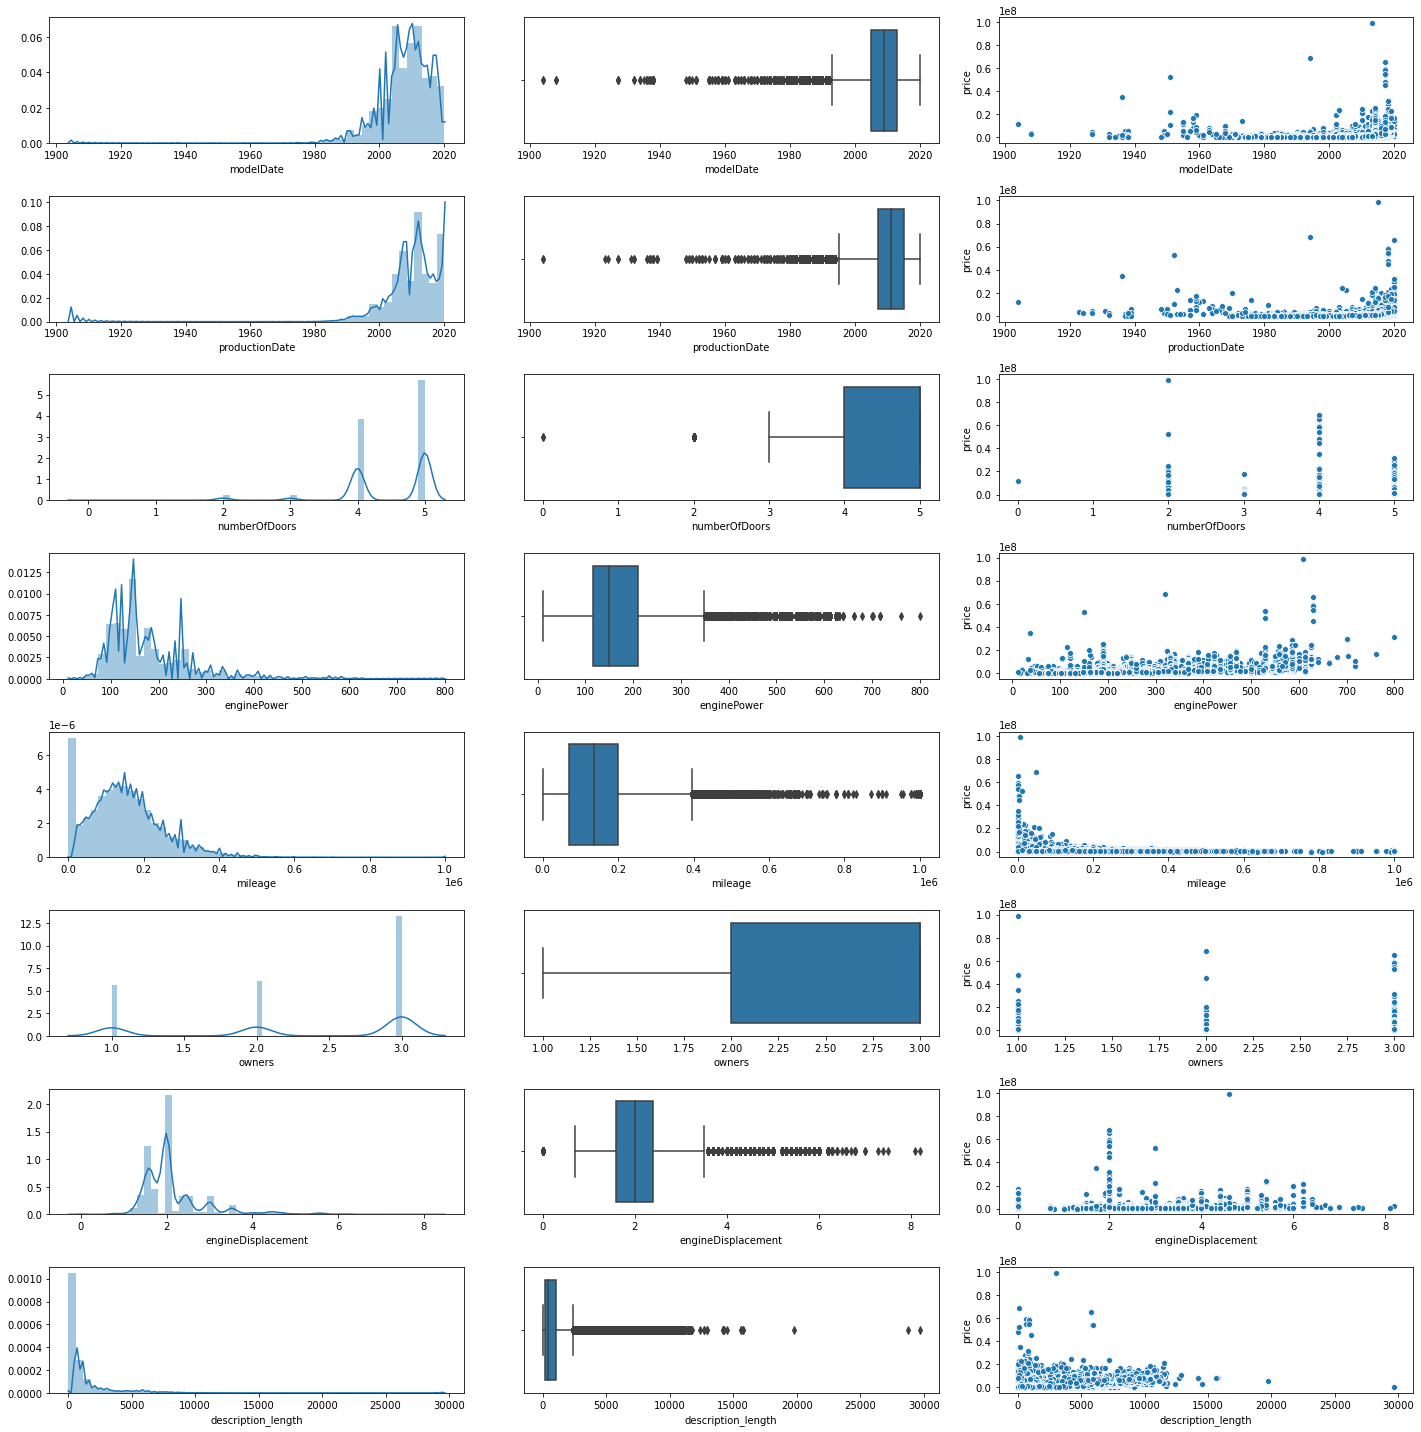

In [120]:
# Построим распределение числовых признаков^

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(8, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(df[col], ax=axes[i],kde_kws={'bw':0.1})
    i = i + 1
    sns.boxplot(df[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=df[df['sample'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1
plt.tight_layout()

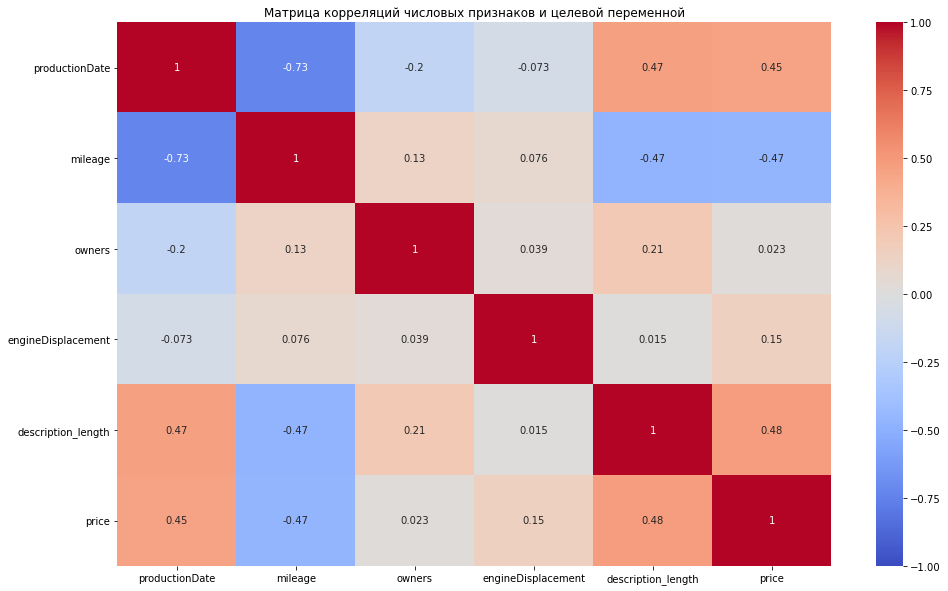

In [121]:
# Построим матрицу корреляций для числовых признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых признаков и целевой переменной')
plt.show()

Оценка важности числовых признаков на целевую переменную


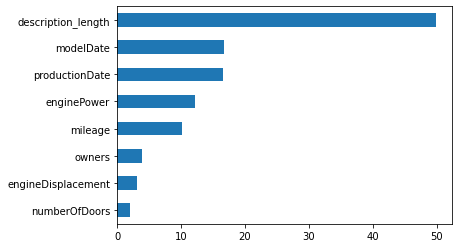

In [122]:
print('Оценка важности числовых признаков на целевую переменную')
imp_num = pd.Series(f_classif(
    df[df['sample'] == 1][num_cols], df[df['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Выводы:

- 5 из девяти признаков имеют практически нормальное распределение со смещением. Новых автомобилей больше, чем старых.

- Большиинство автомобилей с пробегом больше 100 тыс км, которыми вдадели не менее трех человек.

- Год выпуска марки и год производства авто сильно коррелируют друг с другом, так же они оба сильно коррелируют с пробегом, что выглядит вполне логично.

- Нулевые значения есть только в пробеге и количестве дверей(это старый автомобиль 1904 года).

- Два признака (Количество дверей и Владельцы) лучше перевести в категориальные.

In [123]:
df.drop(['modelDate'], axis=1,inplace=True)

In [124]:
num_cols.remove('modelDate')

In [125]:
num_cols.remove('owners')
cat_cols.append('owners')
num_cols.remove('numberOfDoors')
cat_cols.append('numberOfDoors')

In [126]:
print(num_cols)
print(cat_cols)

['modelDate', 'enginePower', 'mileage', 'engineDisplacement', 'description_length']
['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'driveUnit', 'owners', 'numberOfDoors']


#### КАТЕГОРИАЛЬНЫЕ И БИНАРНЫЕ ПЕРЕМЕННЫЕ

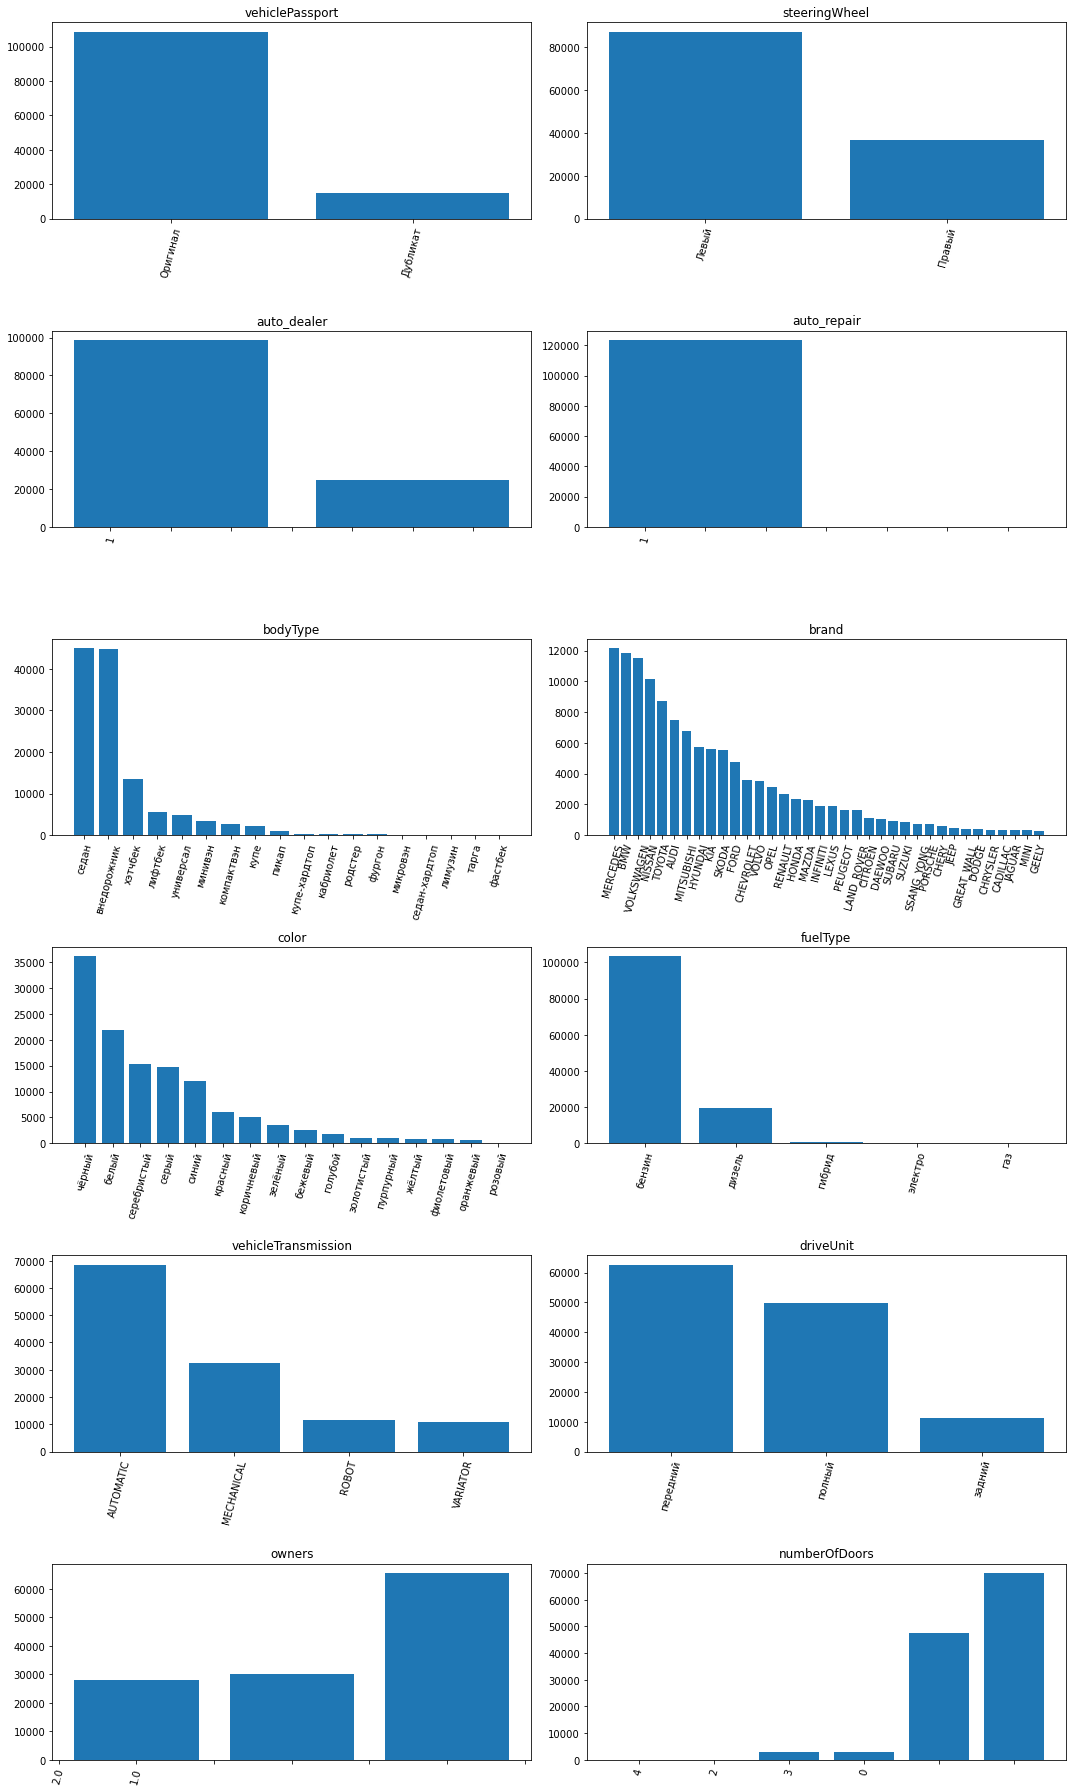

In [127]:
# Построим распределение основных бинарных и категориальных признаков
# не беря в расчет признаки с большим количеством категорий:

fig, axes = plt.subplots(6, 2, figsize=(15, 25))
plt.subplots_adjust(wspace=0.5)
fig.tight_layout()
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    axes[i].set_title(col)
    axes[i].bar(df[col].value_counts().index, df[col].value_counts().values)
    axes[i].set_xticklabels(df[col].value_counts().index, rotation=75)
    plt.title(col)
    i = i + 1

plt.tight_layout()

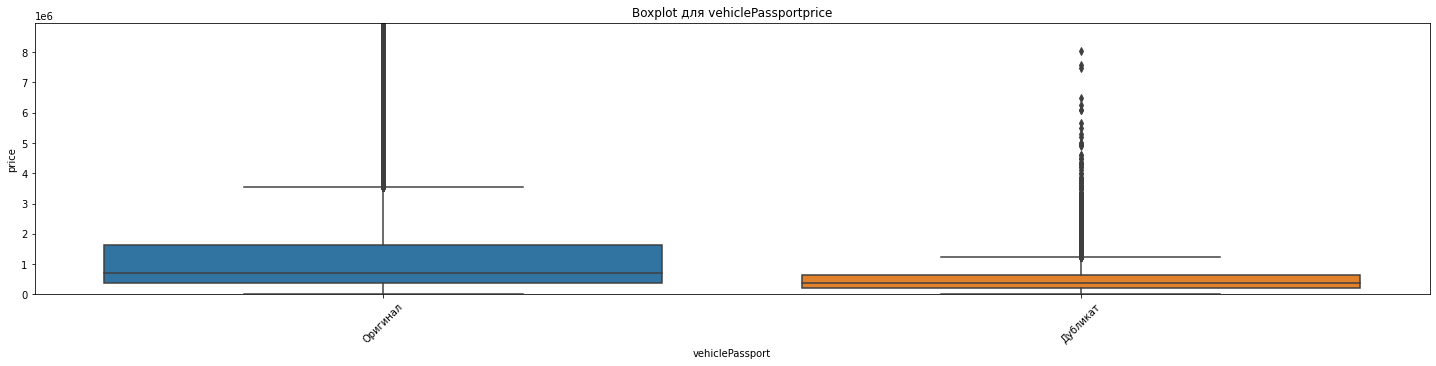

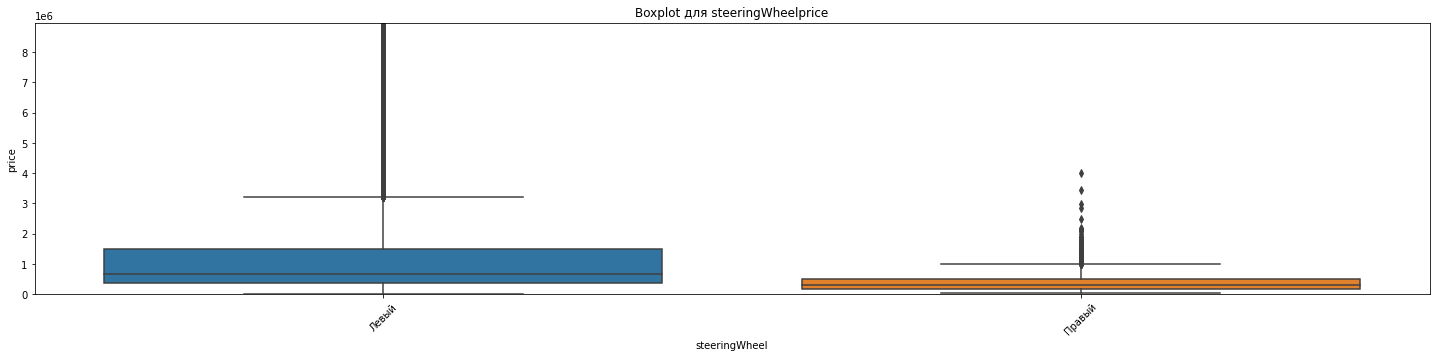

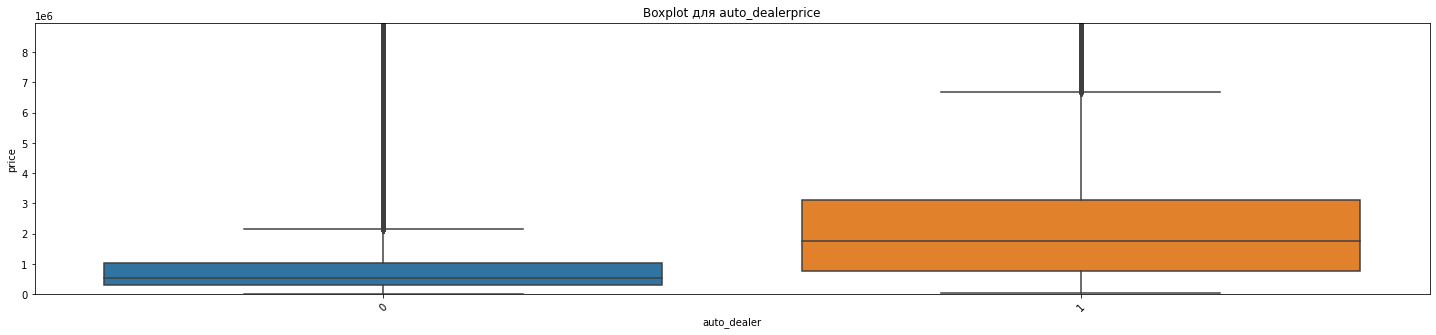

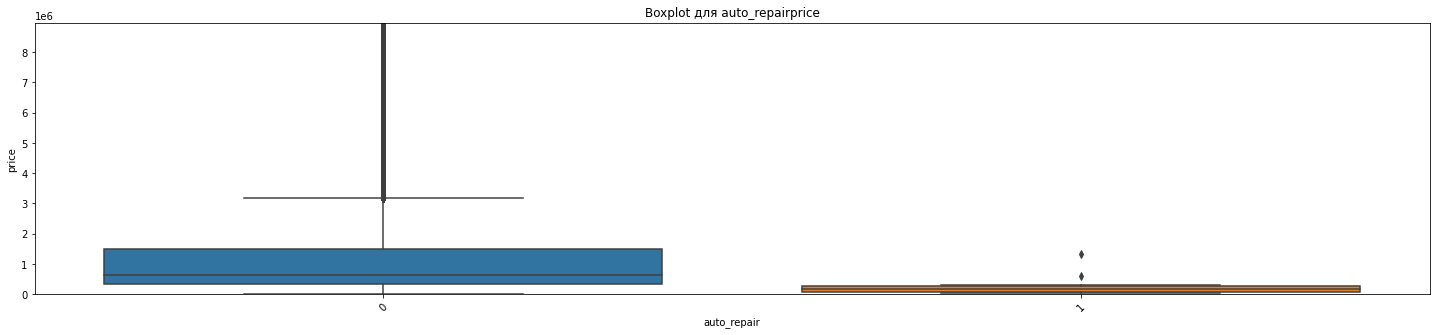

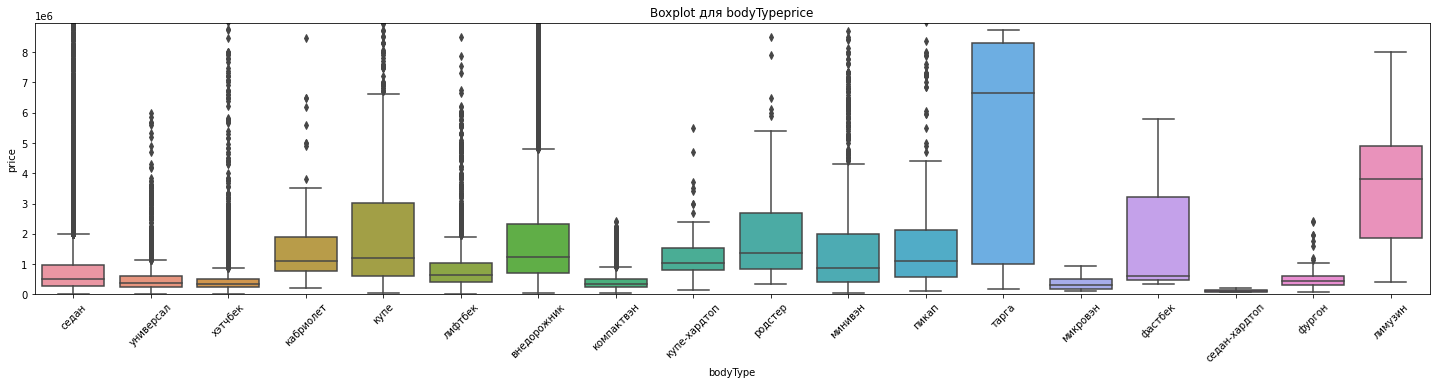

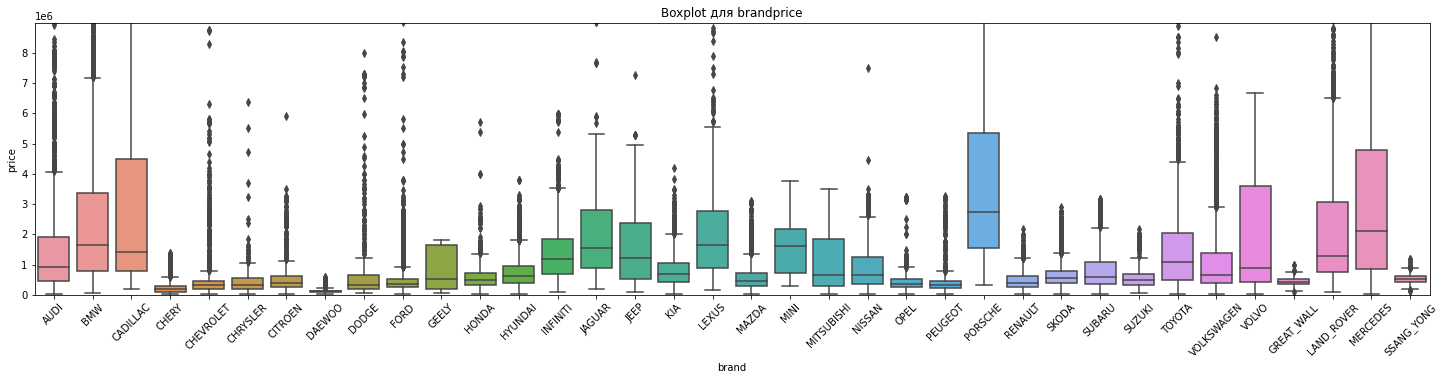

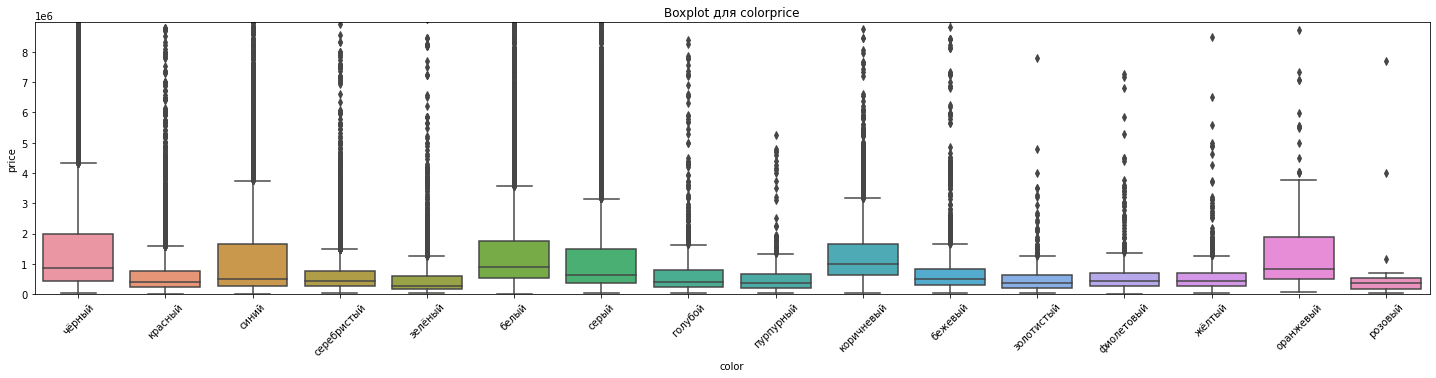

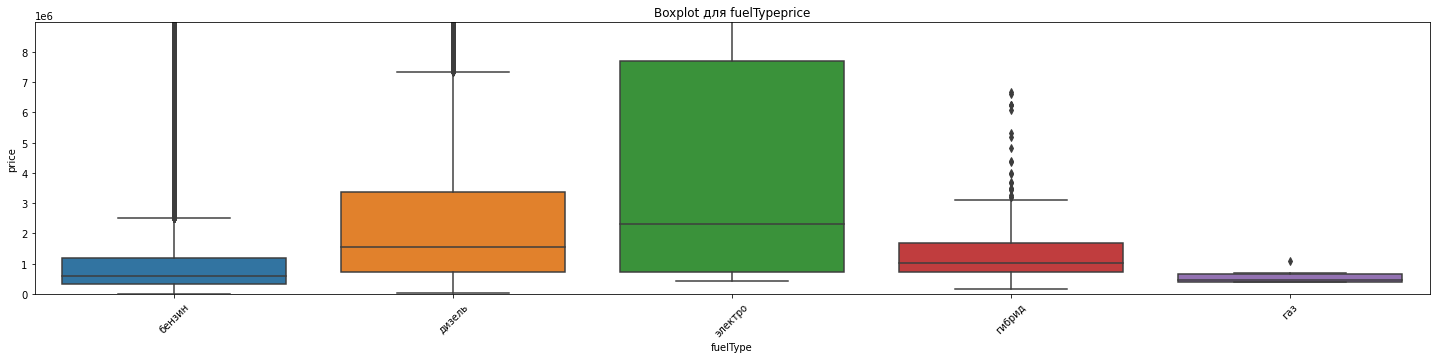

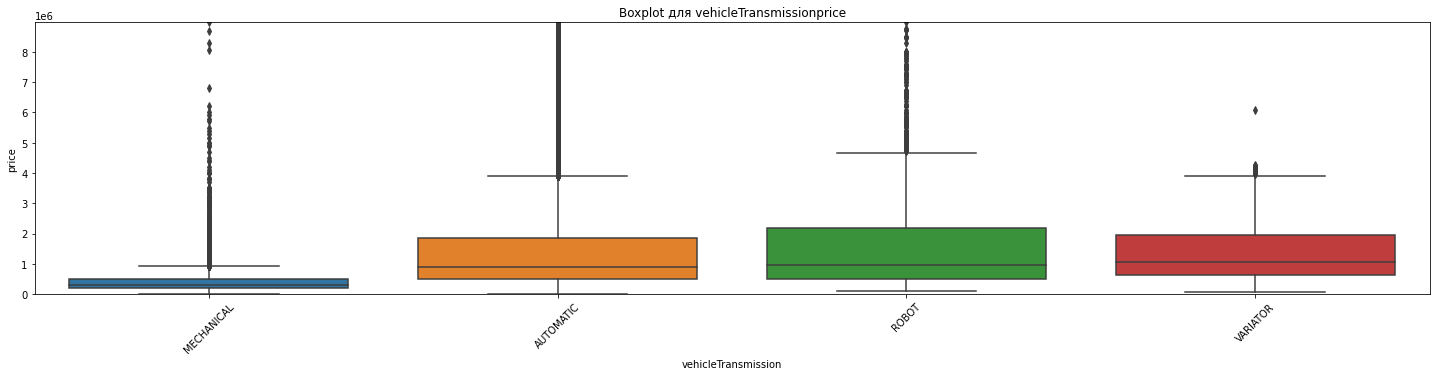

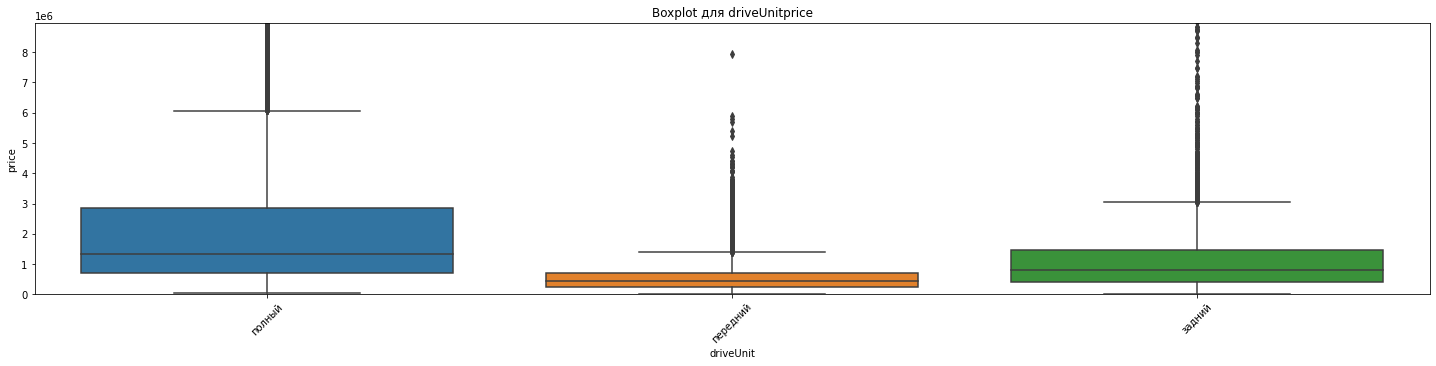

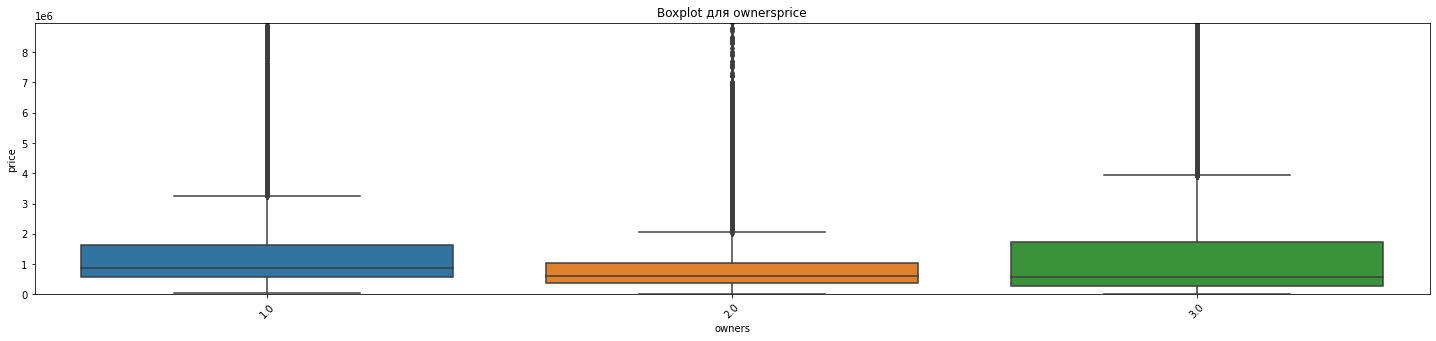

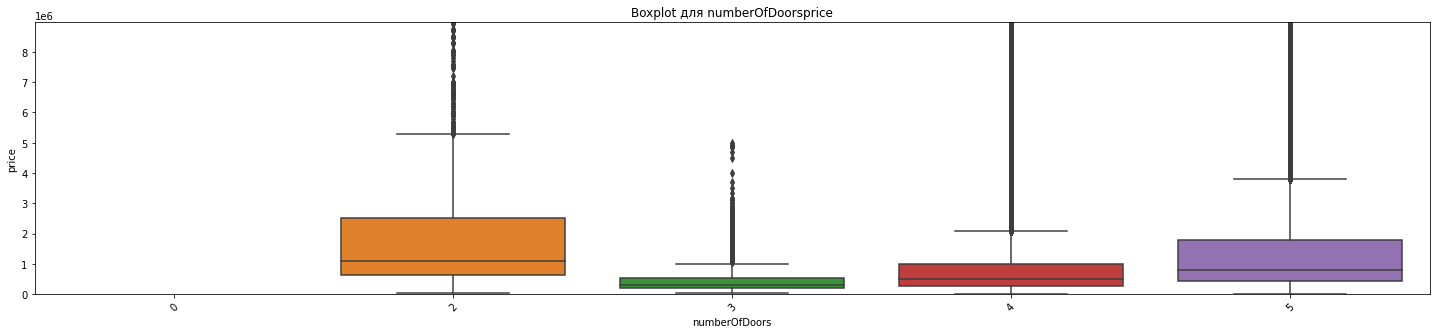

In [128]:
# построим боксплоты для бинарных и категориальных признаков: 
for col in (bin_cols + cat_cols):    
    get_boxplot(col)

#### Выводы: 

Относительно сбалансировнные признаки: owners, vohicleTransmission, driveUnit. Превалируют авто с количеством владельцев 3, с автоматической коробкой передач и с передним либо полным приводом. По отношению к цене: самые дорогие машины с полным приводом, минимальным количеством владельцев, коробкой передач ROBOT.

Плохо сбалансированные признаки:

- vehiclePassport - авто в основном с оригиналом ПТС и цена таких машин выше

- steeringWheel - леворульных машин больше и они дороже праворульных

- auto_repair - количество машин на запчасти значительно ниже и их цена тоже ниже

- auto_dealer - машин продающихся через официальных дилеров больше и их цена тоже выше

- brand - 4 марки (MERCEDES ,BMW, VOLKSWAGEN, NISSAN) составляют больше 30 % от числа всех остальных брендов, из которых к самым догорим относится только MERCEDES. 

- bodyType - много видов кузова, превалирют "седан" и "внедорожник", по цене самые дорогие лимузин и тарга, но их количество не превышает 20 единиц.

- color - из 16 цветов самый распространенный черный, за ним идут белый, серебристый, серый и синий. К самым дорогим цветам оносятся черний, синий, белый , коричневый и оранженый.

- fuelType - тип топлива превалирует -бензин, но самые дорогие авто с электродвигателем, хотя и х количество минимально.

- numberOfDoors - в осном две авто пятидверные, по дороговизне они занимают второе место после двухдверных.



## Анализ целевой переменной (price)

In [132]:
df.price[df['sample'] == 1].describe()

count    8.896700e+04
mean     1.294600e+06
std      1.950417e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.500000e+05
75%      1.480000e+06
max      9.900000e+07
Name: price, dtype: float64

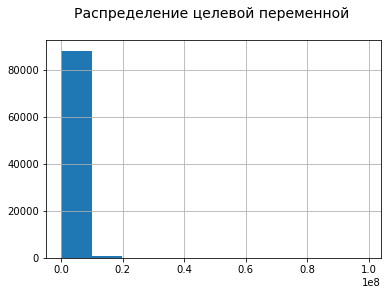

In [133]:
# посмотрим на распределение целевой переменной:
df.query('sample == 1').price.hist();
plt.title("Распределение целевой переменной \n", fontdict={'fontsize': 14});
plt.show()

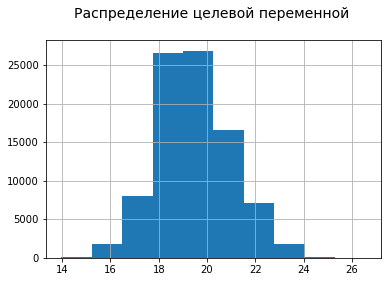

In [134]:
np.log2(df.query('sample == 1').price).hist()
plt.title('Распределение целевой переменной \n', fontdict={'fontsize': 14})

# добавили новый признак в датасет:
df['price_log'] = np.log2(df.price)

После логарифмирвания целевая переменная имеет распределение приближенное к нормальному.

## Работа с выбросами

In [135]:
# Проанализируем выбросы для числовых признаков
print("Отчет о наличии выбросов.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_test(df[col])
    print("-" * 100)

Отчет о наличии выбросов.


Признак:  modelDate

25-й перцентиль: 2005.0, 
75-й перцентиль: 2013.0, 
IQR: 8.0,  
Границы выбросов: [1993.0, 2025.0]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака: Количество: 4435, 3.59%
----------------------------------------------------------------------------------------------------

Признак:  enginePower

25-й перцентиль: 117.0, 
75-й перцентиль: 210.0, 
IQR: 93.0,  
Границы выбросов: [-22.5, 349.5]. 

Минимальное значение признака: 11. 
Максимальное значение признака: 800 .

Найдены выбросы по верхней границе признака: Количество: 5793, 4.68%
----------------------------------------------------------------------------------------------------

Признак:  mileage

25-й перцентиль: 69352.0, 
75-й перцентиль: 200000.0, 
IQR: 130648.0,  
Границы выбросов: [-126620.0, 395972.0]. 

Минимальное значение признака: 0. 
Максимальное значение признака: 1000000 .

Найдены выбросы по ве

Выбросов не так много и они похожи на реальные данные. Например, раритетный автомобиль без дверей, который может стоить очень дорого. Самые большие выбросы присутствуют в целевой переменной. Но избавляться от них не будем.

# Feature Engineering

In [137]:
#Создадим числовой столбец возраст ('age'). С учетом того, что все даные взяты в 2020 году от него и будем отталкиваться:
df['age']= 2020-df.productionDate

In [138]:
df.age[(df.age<10)].value_counts()

9    6909
3    6752
8    6528
2    5587
7    5528
6    5457
5    5155
4    4175
1    2070
0    1553
Name: age, dtype: int64

In [140]:
# На его основе сделаем бинарный признак для автомобилей с возрастом 10 лет и старше (0 - моложе 10 лет):
df['age_old'] = df.age.apply(lambda x: 0 if x<10 else 1)

In [141]:
df.age_old.value_counts()

1    73939
0    49714
Name: age_old, dtype: int64

In [142]:
# Создадим аналогичный признак по пробегу больше 120000 км (примерно половина выборки), где 0-авто с меньшим пробегом:
print(df.mileage[(df.mileage > 120000)].value_counts().sum())
df['mileage_120000'] = df.mileage.apply(lambda x: 1 if x > 120000 else 0)

69340


In [143]:
df.mileage_120000.value_counts()

1    69340
0    54313
Name: mileage_120000, dtype: int64

In [144]:
# добавим новые признаки в бинарные переменные:
bin_cols.append('age_old')
bin_cols.append('mileage_120000')

In [145]:
bin_cols

['vehiclePassport',
 'steeringWheel',
 'auto_dealer',
 'auto_repair',
 'age_old',
 'mileage_120000']

In [146]:
# избавимся от буквенных значений в бинарных признакаx:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [147]:
df[bin_cols].sample(5)

,vehiclePassport,steeringWheel,auto_dealer,auto_repair,age_old,mileage_120000
117297,1,1,0,0,1,1
100910,1,1,1,0,1,1
105514,1,1,0,0,0,0
93227,1,1,0,0,1,1
15079,0,0,0,0,1,1


In [ ]:
#bin_cols.remove('age_old')
#bin_cols.remove('mileage_120000')

In [148]:
# применяем Labels encoding к категориальным признакам c большим количеством категорий:
for col in cat_cols_many:
    df[col] = df[col].astype('category').cat.codes 

In [149]:
df[cat_cols_many]

,name,model_name
0,2245,1
1,844,1
2,1703,1
3,844,1
4,1266,1
...,...,...
124059,3072,45
124060,3752,60
124061,3764,60
124062,2361,1053


In [150]:
# закодируем остальные категоральные переменные:
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes 

In [151]:
df[cat_cols]

,bodyType,brand,color,fuelType,vehicleTransmission,driveUnit,owners,numberOfDoors
0,11,0,15,0,1,2,2,3
1,11,0,7,0,1,1,2,3
2,14,0,13,0,1,2,2,4
3,11,0,11,0,1,1,2,3
4,11,0,15,0,1,1,2,3
...,...,...,...,...,...,...,...,...
124059,11,1,6,0,0,0,2,3
124060,11,1,15,3,0,2,0,3
124061,11,1,12,0,0,0,2,3
124062,0,1,6,3,0,2,1,4


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123653 entries, 0 to 124063
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123653 non-null  int8   
 1   brand                123653 non-null  int8   
 2   color                123653 non-null  int8   
 3   fuelType             123653 non-null  int8   
 4   modelDate            123653 non-null  object 
 5   name                 123653 non-null  int16  
 6   numberOfDoors        123653 non-null  int8   
 7   vehicleTransmission  123653 non-null  int8   
 8   engineDisplacement   123653 non-null  float64
 9   enginePower          123653 non-null  object 
 10  mileage              123653 non-null  int64  
 11  driveUnit            123653 non-null  int8   
 12  steeringWheel        123653 non-null  int64  
 13  owners               123653 non-null  int8   
 14  vehiclePassport      123653 non-null  int64  
 15  price            

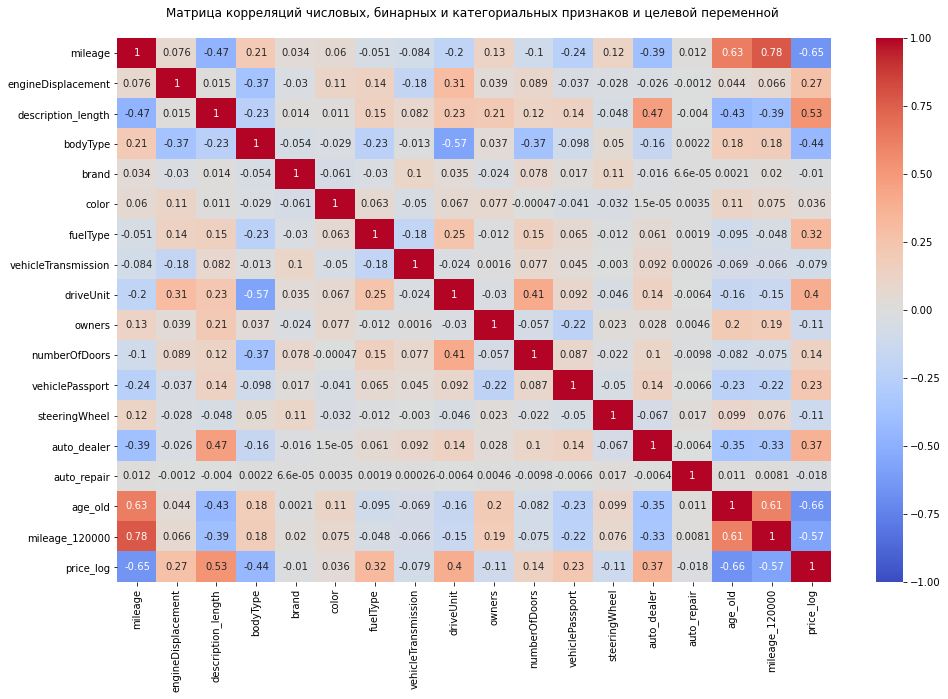

In [153]:
# Построим матрицу корреляций для числовых, бинарных и категориальных признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+cat_cols+bin_cols + ['price_log']].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых, бинарных и категориальных признаков и целевой переменной \n')
plt.show()

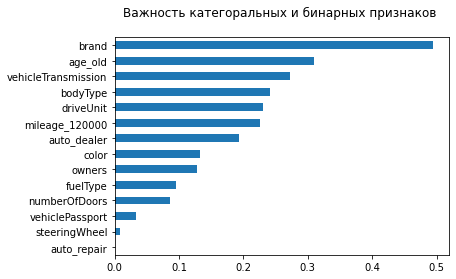

In [154]:
# Теперь посмотрим на важность бинарных и категоральных признаков логарифмированному таргету
imp_cat = pd.Series(
    mutual_info_regression(
        df[df['sample'] == 1][list(set(df.columns) & set(cat_cols+bin_cols))],
        df[df['sample'] == 1]['price_log'],
        discrete_features=True), index=list(set(df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Важность категоральных и бинарных признаков \n')
plt.show()

Корреляция признаков присутствует, но пока не будем ничего удалять. Возможно нам все понадобится.

# Machine Learning

## Split

In [155]:
# Создадим первое разделение для наивной модели:
X = df.query('sample == 1').drop(['sample', 'sell_id','price', 'price_log'], axis=1)
X_sub = df.query('sample == 0').drop(['sample', 'sell_id','price','price_log'], axis=1)


In [156]:
y = df.query('sample == 1').price

In [157]:
X.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,vehicleTransmission,engineDisplacement,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,model_name,description_length,auto_dealer,auto_repair,age,age_old,mileage_120000
5096,14,1,2,0,1990,3147,4,1,2.0,150,10000,0,0,2,0,45,56,0,0,30,1,0
20766,11,9,12,0,2005,803,3,1,1.8,125,174425,1,0,2,1,411,57,0,0,15,1,1
48785,0,24,12,0,2017,1234,4,3,2.0,144,22000,1,0,1,1,764,564,0,0,3,0,0


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [159]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

## Модель 1 - Наивная модель

In [160]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 74.50%


In [161]:
model1 = LinearRegression()
model1.fit(X_train,y_train)

#Предсказываем значения
y_predict = model1.predict(X_test)

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 103.32%


## Модель 2 - CatBoost

Модель CatBoostRegressor хорошо работает с категориальными признаками, числовые признаки надо прологарифмировать для использования.Параметры для этой модели были взяты из Baseline.

In [162]:
# Применим логарифмирование ко всем числовым признакам
for col in num_cols:
    df[col] = df[col].apply(lambda w: np.log(w+1))

In [163]:
df[num_cols] # проверяем логарифмировние числовых признаков

,modelDate,enginePower,mileage,engineDisplacement,description_length
0,7.596392,5.164786,12.765691,1.335001,5.433722
1,7.592366,4.510860,12.063501,1.029619,4.890349
2,7.595387,4.919981,12.345839,1.193922,7.045777
3,7.595387,4.510860,12.388398,1.029619,1.386294
4,7.596392,4.624973,12.611541,1.098612,5.323010
...,...,...,...,...,...
124059,7.606885,4.919981,11.652696,0.955511,6.028279
124060,7.609367,5.252273,11.492733,1.098612,3.433987
124061,7.598900,5.141664,12.793862,1.252763,2.890372
124062,7.607381,5.220356,11.413116,1.098612,6.391917


In [164]:
# готовим  бырорку для обучения и тестовой частей:
X_2_1 = df.query('sample == 1')[cat_cols + bin_cols+num_cols + cat_cols_many]
X_sub_2_1 = df.query('sample == 0')[cat_cols + bin_cols+num_cols + cat_cols_many]

In [165]:

X_train, X_test, y_train, y_test = train_test_split(X_2_1, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)


In [166]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Результат заметно улучшился. Попробуем другие модели и посмотрим как работают другие модели по сравнению с CatBoost 

Разбиение, используемое на второй модели менять не будем.

## Модель 3 RandomForestRegressor

In [167]:
rf = RandomForestRegressor(random_state = RANDOM_SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
rf_log.fit(X_train, np.log(y_train))
rf_log_pred = np.exp(rf_log.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 14.51%
Точность модели по метрике MAPE с логтаргетом: 13.03%


In [ ]:
# Подбор гирерпараметров для модели:
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#               'max_features': ['sqrt', 'log2'],
#              'max_depth': [int(x) for x in np.linspace(1, 10, num=10)] + [None],
#               'min_samples_split': [2, 5, 10],
#              'min_samples_leaf': [1, 2, 4],
#'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                               n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)

#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_

Гиперпараметры искала дважды с немного разными сетками, второй вариант дал результат чуть лучше, но при bootstrap: True

Fitting 3 folds for each of 100 candidates, totalling 300 fits

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

In [168]:
# Обучим модель на лучших гиперпараметрах вариант 1

best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='log2'
                      , max_depth=None
                      , bootstrap=True)

best_rfr.fit(X_train, np.log(y_train))

predict_rfr = np.exp(best_rfr.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 13.13%


In [169]:
# Обучим модель на лучших гиперпараметрах вариант 2

best_rfr_1 = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=800
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='log2'
                      , max_depth=None
                      , bootstrap=True)

best_rfr_1.fit(X_train, np.log(y_train))

predict_rfr = np.exp(best_rfr_1.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 13.09%


ТОР результат на сабмишн (1 вариант)12,07%

ТОР результат на сабмишн (2 вариант)12,22%


Логарифмирование таргета сильно улучшает показатель MAPE, поэтому в дальнейшем будем использовать только логтаргет. Что касается гиперпарамеров, то они улучшили ситуацию, но не сильно. Результат проверялся на кагле с гиперпараметрами.

## Модель 4 - LGBMRegressor 

In [ ]:
# Запустим модель со стандартными параметрами
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Здесь ситуация ухудшилась, теперь давайте попробуем с гиперпараметрами.

In [ ]:
# Поиск гиперпараметров занимает почти вечность, поэтому здесь шел подбор опытным путем:
lgbm = LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000,
                         n_estimators=100, learning_rate=0.01, num_leaves=1000, 
                         min_child_samples=3,  colsample_bytree=0.5)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Как мы видим, здесь результат улучшился.

## Модель 5 - XGBRegressor

In [ ]:
# Параметры подбирались вручную
xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.05,
    max_depth=12,
    alpha=1,
    n_estimators=1000,
    #random_state=RANDOM_SEED,
    n_jobs=-1)

xgb.fit(X_train, np.log(y_train))
predict_xgb = np.exp(xgb.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_xgb))*100:0.2f}%")

Результат ЧУТЬ немного улучшился.

## Модель 6 -Extra Tree Regressor с подбором гиперпараметров

In [ ]:
# Запустим модель со стандартными параметрами
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

In [ ]:
# Попробуем подобрать гиперпараметры для нашей модели

#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
#etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid,
#                                n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)
# rf_random.fit(X_train, y_train)
#etr_random.fit(X_train, np.log(y_train))
#etr_random.best_params_

In [ ]:
# Запустим модель с подобранными параметрами:
best_etr = ExtraTreesRegressor(n_estimators = 100,
                               min_samples_split= 2,
                               min_samples_leaf= 1,
                               max_features= 'auto',
                               max_depth= 15,
                               bootstrap= False,
                               random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
best_etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(best_etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

Поиск гиперпараметров не помог вообще, и даже хуже сделал, хотя и занял очень долгое время.

# СТЕКИНГ

### Попробуем использовать стекинг для построения моделей. В качестве базовых моделей возьмем наиболее успешные: LGBMRegressor, Xgboosting и ExtraTreeRegressor, показавшие наибольший результатна каггле.

## Стекинг:LGBMRegressor, Xgboosting +LinearRegression

In [ ]:
import xgboost as xgb

In [ ]:
estimators = [('lgbm', LGBMRegressor(random_state=RANDOM_SEED, objective='regression', num_iterations=1000,
                                     n_estimators=100, learning_rate=0.01, num_leaves=1000,
                                     min_child_samples=3,  colsample_bytree=0.5)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
                                           max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble_1 = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble_1.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Как мы видим, это самый лучший результат проекта.

## Стекинг: Xgboosting, ExtraTreesRegressor+LinearRegression

In [ ]:
import xgboost as xgb

In [ ]:
estimators = [('etr',ExtraTreesRegressor()),
              ('xgb_reg',xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# оцениваем точность
st_ensemble.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

ТОР результат на сабмишен 12,11%

В результате первый вариант стекинга показал себя лучше всего. На его основе и будем делать окончательный сабмишн.

Интересно, что показатели метрики на обучении практически всегда были ниже, чем на ТОП сабмишн.



## Submission

In [ ]:
#sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
#predict_sub = np.exp(st_ensemble_1.predict(X_sub_2_1))
#sample_submission['price'] = predict_sub
#sample_submission.to_csv('submission.csv', index=False)
#sample_submission.head(10)

## Conclusions

Результат получился довольно неплохой, с учетом того, что использован был только базовый набор данных. 

Однако на каггле очень медленно обрабатываются модели, особенно стекинг. 

Для улучшения результата необходимо более тщательно обрабатывать признаки и использовать другие методы кодирования категориальных признаков. Также необходима работа в команде, нехватка времени и мощности сказалась на результате.


В целом удалось на практике  проработать материал модуля(и плюс Библиотеку Selenium) и  получить хороший результат с учетом работы в одиночку.

